# EDA project as part of the neuefische Data Science Bootcamp 2024

---

# Introduccion

This notebook was created as part of the DataSience Bootcamp, which I attended in spring 2024 to make my way out of academia and into the world of data and predictions. 

The aim of this EDA project is to demonstrate what we've learnt over the last few weeks in a (slightly) larger project and to help a simulated customer find a house.

---

## About the Client

![client](./misc/client.jpeg)

## Questions

In order to help the client find two houses, i'll guide the EDA along the following questions:

- How does the location affect the price of the house?
- Does the time of the year affect houses prices?
   - And if so, what other factors may influence this dependency?

## Hypothesis

Moreover, the following specific hypotheses will underpin the conclusions drawn from the data and support the final recommendations:

1. Houses in the city are more expensive than in the countryside.
2. The fluctuation of house prices over the course of the year depends on the region.
3. Houses in need of renovation are less affected by price fluctuations.

---

## About the Dataset

The dataset, provided by neuefische, is a version of the widely used dataset of house sale prices for King County, which includes Seattle. It consists of homes sold between May 2014 and May 2015, and consists of the following columns/features:

| column name | description |
| --- | ----------- |
| id | unique identified for a house |
| date | house was sold |
| price | is prediction target |
| bedrooms | # of bedrooms |
| bathrooms | # of bathrooms |
| sqft_living | footage of the home |
| sqft_lot | footage of the lot |
| floors | floors (levels) in house |
| waterfront | House which has a view to a waterfront |
| view | quality of view |
| condition $^1$ | How good the condition is ( Overall ) |
| grade $^1$ | overall grade given to the housing unit, based on King County grading system |
| sqft_above | square footage of house apart from basement |
| sqft_basement | square footage of the basement |
| yr_built | Built Year |
| yr_renovated | Year when house was renovated |
| zipcode | zip |
| lat | Latitude coordinate |
| long | Longitude coordinate |
| sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors |
| sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors |

$^1$: more information about the _Grade_ & _Condition_ categories may be [found here](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)

---

# Preparations

## Import libraries & set global settings

In a first step, import the needed library and define global settings.

In [1]:
# --- import --- hide code ---
import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
from geopy.distance import distance 
from shapely.geometry import Polygon, LineString, Point
import shapely
from area import area
import math
from scipy import stats
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# plot styles
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pacoty.mplstyle')

%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"

sns.set_theme(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
#sns.set_style("ticks")

# format numbers to be in 'million'
def formatter(x, pos=0):
    return str(round(x / 1e6, pos)) + " mil." if x > 100000 else str(x)

## Import raw data from csv & geojson files

Import raw dataset from csv and geojson files for Choroplots. Also, get rid of variables, features and columns which are not used anyway & rename columns to `lower_case()`.

A geojson file, containing the geometry of the different districts in King County, was [downloaded here](https://gis-kingcounty.opendata.arcgis.com/datasets/e6c555c6ae7542b2bdec92485892b6e6/explore?filters=eyJDT1VOVFlfTkFNRSI6WyJLaW5nIENvdW50eSJdfQ%3D%3D&location=47.984717,-122.226505,8.75)

In [2]:
# --- import data --- hide code ---
# import the data from a csv-file + drop 'id'
df = pd.read_csv(os.path.join('data', 'eda.csv'))
df.drop(columns=['id'], inplace=True)
df.columns = map(str.lower, df.columns)

# load GeoJSON
geo_json = os.path.join('data', 'KingCounty.geojson')
with open(geo_json, 'r') as jsonFile:
    geo_json_data = json.load(jsonFile)

# open GeoJSON file as geopandas & preprocess it a bit
gdf = gpd.read_file(geo_json)
gdf.drop(columns=['OBJECTID', 'ZIPCODE','COUNTY', 'Shape_Area', 'Shape_Length'], inplace=True)
gdf.rename(columns={'COUNTY_NAME': 'COUNTY', 'ZIP': 'zipcode', 'PREFERRED_CITY': 'city'}, inplace=True)
gdf.drop(index=gdf[gdf['COUNTY'] != 'King County'].index, inplace=True)
gdf.reset_index(drop=True, inplace=True)
gdf.columns = map(str.lower, gdf.columns)

# load pre_calculated distance matrix between every house (precalculated, because this took some minutes)
#############

---

# Functions

Here I define functions which come handy in the course of this analysis. These are:
- convert square_feet to _square_meters

In [3]:
# --- functions --- hide code ---
# convert square_feet to square_meters
def sqft2sqm(cols):
    for col in cols:
        if col in df.columns:
            df[col.replace('sqft', 'sqm')] = df[col].apply(lambda x: x / 10.764).round(2)
            df.drop(columns=[col], inplace=True)


# convert POLYGON to square_meters
def poly2sqm(geometry):
    if geometry.geom_type != 'Polygon':
        polies = list(geometry.geoms)
    else:
        polies = [geometry]

    a = 0
    for poly in polies:
        _, _coords, _ = shapely.to_ragged_array([poly])
        _coords = _coords.tolist()
        poly_dict = {'type': 'Polygon', 'coordinates': [_coords]}
        a += area(poly_dict) / 1000000
    return a


# calculate distance between to samples, either betwwen coordinates and/or polygons
def calc_dist_x2y(x, y):
    def check_type(z):
        if not isinstance(z, tuple):
            _, zz, _ = shapely.to_ragged_array([z])
            zz_arr = zz.mean(axis=0)
            z = tuple(zz_arr[::-1])
        return z

    xx, yy = check_type(x), check_type(y)
    return round(distance(xx, yy).km, 3)


# define which residential type a district is defined as
def define_urbanization(dist, dens):
    if dist < 11:
        return 'city'
    elif dist > 30 and dens < 2:
        return 'countryside'
    else:
        return 'suburbs'


# plot correlation lower-triangle
def display_corr_matrix(data, thresh=None):
    """
    Display a heatmap from a given dataset

    :param data: dataset
    :param thresh: float
    :return: g (graph to display)
    """
    # Create a correlation matrix & a mask for the lower triangle
    corr = data.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = None

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(240, 10, sep=20, n=9, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    annot = False if thresh is None else True
    plt.figure(figsize=(10, 10))
    g = sns.heatmap(corr, cmap=cmap, mask=mask, square=True, annot=annot,
                    center=0, cbar_kws={"shrink": 0.5, 'label':'Pearson r'})
    g.grid(False)

    if thresh is not None:
        for t in g.texts:
            if float(t.get_text())>=thresh:
                t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
            else:
                t.set_text("") # if not it sets an empty text

    return g


# display various kinds of plots
def display_plot(data, features, target, plot_type='box', cols=3):
    """
    Generates a seaborn boxplot (default) or scatterplot

    :param data: dataset
    :param features: feature list
    :param target: feature name
    :param plot_type: box (default), scatter, regplot
    :param cols: # of columns (default: 2)
    :return: g
    """

    # define size of subplots
    ncol = cols
    nrow = math.floor((len(features) + ncol - 1) / ncol)

    # create the axes
    _, axarr = plt.subplots(nrows=nrow, ncols=ncol, figsize=(8*ncol, 5*nrow))

    # go over a linear list of data
    for i in range(len(features)):
        # compute an appropriate index (1d or 2d)
        ix = np.unravel_index(i, axarr.shape)

        if plot_type == 'box':
            g = sns.boxplot(y=features[i], x=target, data=data, width=0.8,
                            orient='h', showmeans=True, fliersize=3, ax=axarr[ix])
            axarr[ix].set_ylabel('')
            axarr[ix].set_title(features[i])

        elif plot_type == 'violin':
            g = sns.violinplot(y=features[i], x=target, data=data, width=0.8,
                            orient='h', cut=0, ax=axarr[ix])
            axarr[ix].xaxis.set_major_formatter(formatter)

        elif plot_type == 'scatter':
            g = sns.scatterplot(x=features[i], y=target, data=data, ax=axarr[ix])

        elif plot_type == 'regplot':
            g = sns.regplot(x=features[i], y=target, data=data, ax=axarr[ix], 
                            line_kws=dict(color="k"), scatter_kws={'s':7}, ci=100)
            sns.rugplot(x=features[i], y=target, data=data, ax=axarr[ix],
                        expand_margins=False, height=.025, c=[0.7, .7, .7])

            r = stats.pearsonr(data[features[i]], data[target])
            axarr[ix].text(data[features[i]].max(), data[target].max(),
                           f"Pearson r = {round(r.correlation, 3)}",
                           horizontalalignment='right', verticalalignment='top')
            axarr[ix].yaxis.set_major_formatter(formatter)

    # turn off unused axes
    for j in range(i+1,ncol*nrow):
        jx = np.unravel_index(j, axarr.shape)
        axarr[jx].set_axis_off()

    return g


# map plot: show markers for dataframe
def map_seperate_houses(d, txt):
    loc_map = d[['lat', 'long']].mean().tolist()

    m = folium.Map(location=loc_map, tiles=None, zoom_start=10)
    folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True
        ).add_to(m)
    folium.TileLayer(
        tiles = "OpenStreetMap",
        overlay = False,
        control = True
        ).add_to(m)
    folium.LayerControl().add_to(m)

    for i in range(0,len(d)):
        loc = [d.iloc[i]['lat'], d.iloc[i]['long']]
        folium.Marker(location=loc,
                      tooltip=txt + ': ' + str(d.iloc[i][txt])
                      ).add_to(m)

    return m


# map plot: CHOROPLETH
def map_choro(gdf, what='zipcode', legend=True, cmap='viridis', tiles="OpenStreetMap.HOT", k=5,
              scheme='JenksCaspall', tooltip=[], caption='', scale=False):
    
    ttip = ['city', 'zipcode'] + tooltip

    g = gdf.explore(
        what,
        legend=legend,
        cmap=cmap, ## coolwarm / 
        scheme=scheme,
        k=k,
        tiles=tiles,
        tooltip=ttip,
        style_kwds={'color': 'black',
                    'weight': 0.5,
                    'fillOpacity': 0.6},
        legend_kwds={'caption': caption,
                     'scale': scale,
                     'fmt': '{:.0f}'})

    return g

---

# Data Cleaning

## Data Inspection

First, inspect the dataframe which contains the raw housing sales data.

In [4]:
# --- inspect --- hide code ---
print(df.info(), '\n')
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  float64
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  float64
 5   sqft_lot       21597 non-null  float64
 6   floors         21597 non-null  float64
 7   waterfront     19206 non-null  float64
 8   view           21534 non-null  float64
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  float64
 12  sqft_basement  21145 non-null  float64
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   17749 non-null  float64
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  2014-10-13 221900.00      3.00       1.00      1180.00   5650.00    1.00   
1  2014-12-09 538000.00      3.00       2.25      2570.00   7242.00    2.00   
2  2015-02-25 180000.00      2.00       1.00       770.00  10000.00    1.00   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0         NaN  0.00          3      7     1180.00           0.00      1955   
1        0.00  0.00          3      7     2170.00         400.00      1951   
2        0.00  0.00          3      6      770.00           0.00      1933   

   yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  
0          0.00    98178 47.51 -122.26        1340.00     5650.00  
1      19910.00    98125 47.72 -122.32        1690.00     7639.00  
2           NaN    98028 47.74 -122.23        2720.00     8062.00

Then, also perform the following steps:

- fix `yr_renovated` -> divide by 10
- check for duplicates
- check for missing data
- edit data types

In [5]:
# --- fix yr_renovated & check duplicates --- hide code ---
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: x / 10)
print('duplicates: ', df.duplicated().value_counts()[False] - df.shape[0])

duplicates:  0


In [6]:
# --- check for missing values --- hide code ---
print('missing values per feature:')
nullseries = df.isnull().sum()
print(nullseries[nullseries > 0])

missing values per feature:
waterfront       2391
view               63
sqft_basement     452
yr_renovated     3848
dtype: int64


There are a few features with missing values:
- _sqft_basement_:
  - area of basement can be calculated from the dataset by `sqft_living - sqft_above`
- _yr_renovated_:
  - not possible to impute
  - furthermore, most (~96%) of the values are `0`
  - column will be dropped
- _view & waterfront_:
  - first, find nearest house, if this is closer than 500m, I assume both houses has the same view/waterfront 
  - if house is further away, the missing value will be imputed with the median view/waterfront of the zipcode


In [7]:
# --- fix missing values --- hide code ---
# basement
df['sqft_basement'] = df.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)

# yr_renovated
df.drop(columns=['yr_renovated'], inplace=True)

# view

# def get_nearest_feat(r, feat):
#     dis = df.apply(lambda x: distance((x['lat'], x['long']), (r['lat'], r['long'])).km, axis=1)

#     # d, i = [], []
#     # for index, row in df.iterrows():
#     #     d.append(distance((row['lat'], row['long']), (r['lat'], r['long'])).km)
#     #     i.append(index)
#     # tmp = pd.DataFrame(data = {'d': d, 'i': i})
#     tmp = dis.sort_values()

#     if tmp[1] < 1:
#         return 77
#         # return df.l[1]
#     else:
#         return 99

# y = df.apply(lambda x: get_nearest_feat(x, 'view') if np.isnan(x['view']) else x['view'], axis=1)

# x = df['view'].fillna(df['zipcode'].map(df.groupby('zipcode')['view'].median().to_dict()))
# nullseries = x.isnull().sum()
# print(nullseries[nullseries > 0])

# view
zip_view_dict = df.groupby('zipcode')['view'].median().to_dict()
df['view'] = df['view'].fillna(df['zipcode'].map(zip_view_dict))

# waterfront
zip_waterfront_dict = df.groupby('zipcode')['view'].median().to_dict()
df['waterfront'] = df['waterfront'].fillna(df['zipcode'].map(zip_view_dict))

# ----- check for missing values -----
print('missing values per feature:')
nullseries = df.isnull().sum()
print(nullseries[nullseries > 0])

missing values per feature:
Series([], dtype: int64)


In [8]:
# --- data types --- hide code ---
# float -> int
df.price = df.price.astype('int64')
df.bedrooms = df.bedrooms.astype('int64')
df.waterfront = df.waterfront.astype('category')
df.view = df.view.astype('int64')

# transform date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

## Add Features

Add new features to dataframe:
- transform square_feet to square_meters
- add _price per square meter_ `price_sqm` as `price`/`living`
- add feature `sqm_garden` which tells about the soze of the garden (`lot - (living/floors)`)
  - this assumes, that the total footage of the house is equally distributed across floors 
- add new date features to be able to group by
  - month
  - week

In [9]:
# --- add features --- hide code ---
# sqft -> sqm
sqft2sqm(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'])

# price per square meter
df["price_sqm"] = df["price"] / df["sqm_living"]

# add size of garden
df["sqm_garden"] = df["sqm_lot"] - (df["sqm_above"] / df["floors"])

# add date features
df["date_month"] = df["date"].dt.month
df["date_week"] = df["date"].dt.isocalendar().week
df['date_year_week'] = df["date"].dt.strftime('%Y-%W') # needed to sort data according to date

## Final descriptive inspection

After cleaning up, check the dataframe once more. But everything looks fine now.

In [10]:
# --- inspect --- hide code ---
print(df.info(), '\n')
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            21597 non-null  datetime64[ns]
 1   price           21597 non-null  int64         
 2   bedrooms        21597 non-null  int64         
 3   bathrooms       21597 non-null  float64       
 4   floors          21597 non-null  float64       
 5   waterfront      21597 non-null  category      
 6   view            21597 non-null  int64         
 7   condition       21597 non-null  int64         
 8   grade           21597 non-null  int64         
 9   yr_built        21597 non-null  int64         
 10  zipcode         21597 non-null  int64         
 11  lat             21597 non-null  float64       
 12  long            21597 non-null  float64       
 13  sqm_living      21597 non-null  float64       
 14  sqm_lot         21597 non-null  float64       
 15  sq

date   price  bedrooms  bathrooms  floors waterfront  view  condition  \
0 2014-10-13  221900         3       1.00    1.00       0.00     0          3   
1 2014-12-09  538000         3       2.25    2.00       0.00     0          3   
2 2015-02-25  180000         2       1.00    1.00       0.00     0          3   

   grade  yr_built  ...  sqm_lot  sqm_above  sqm_basement  sqm_living15  \
0      7      1955  ...   524.90     109.62          0.00        124.49   
1      7      1951  ...   672.80     201.60         37.16        157.00   
2      6      1933  ...   929.02      71.53          0.00        252.69   

   sqm_lot15  price_sqm  sqm_garden  date_month  date_week  date_year_week  
0     524.90    2024.27      415.28          10         42         2014-41  
1     709.68    2253.31      572.00          12         50         2014-49  
2     748.98    2516.43      857.49           2          9         2015-08  

[3 rows x 24 columns]

## GeoJson

### Fix zipcodes for houses

What I spotted during the processing of the geocraphical informations was, that the zipcodes of some of the houses in the DataFrame are not correct. 

Here is an example for the zipcode 98014:
- first figure shows the areas of both zipcodes
- second figure shows where houses are located

In [11]:
# --- map erroneous house location --- hide code ---
# error_zipcodes = [98014, 98224, 98288]
# df_error_loc = df[df['zipcode'].isin(error_zipcodes)]
# m = folium.Map(location=df_error_loc[['lat', 'long']].mean().tolist(), tiles='OpenStreetMap', zoom_start=9)
# for i in range(0,len(df_error_loc)):
#     loc = [df_error_loc.iloc[i]['lat'], df_error_loc.iloc[i]['long']]
#     folium.Marker(location=loc, tooltip='house:' + str(df_error_loc.iloc[i]['zipcode'])).add_to(m)
# for err in error_zipcodes:
#     folium.GeoJson(gdf[gdf['zipcode'] == err], tooltip='district: ' + str(err)).add_to(m)
# m


Clearly, the houses on the upper right are labeled with the wrong zipcode.

Lets correct this by comapring the lat/long coordinates from the _DataFrame_ with the `geometry` property of the _GeoDataFrame_ and find for each house, in which Zipcode-Area it actually is located.

In [12]:
# --- fix zipcodes --- hide code ---
# create geopandas.series conatining house coordinates as POINTS
house_points = gpd.GeoSeries(df.apply(lambda r: Point(r.long, r.lat), axis=1))

# loop through ZIPCODES and check which HOUSE_POINT is within the ZIPCODE_POLYGON
df['zipcode_fix'] = np.nan
for i,z in enumerate(gdf.zipcode.unique()):
    zip_geom = gdf[gdf.zipcode == z]['geometry'][i]
    inZIP = house_points.within(zip_geom)
    df.loc[inZIP, 'zipcode_fix'] = int(z)

# one house's coordinates are just outlide the districts border it belongs to, and therefor was not
# assigned to another zipcode -> set this to his "old" zipcode
df['zipcode_fix'] = df.apply(lambda row: row['zipcode'] if np.isnan(row.zipcode_fix) else row.zipcode_fix, axis=1)

# rename zipcode columns & update datatype
df.rename(columns={'zipcode': 'zipcode_old', 'zipcode_fix': 'zipcode'}, inplace=True)
df['zipcode'] = df['zipcode'].astype('int64')

In [13]:
# --- map erroneous & now FIXED house location --- hide code ---
# df_error_loc = df[df['zipcode'].isin(error_zipcodes)]
# m = folium.Map(location=df_error_loc[['lat', 'long']].mean().tolist(), tiles='OpenStreetMap', zoom_start=9)
# for i in range(0,len(df_error_loc)):
#     loc = [df_error_loc.iloc[i]['lat'], df_error_loc.iloc[i]['long']]
#     folium.Marker(location=loc, tooltip='house:' + str(df_error_loc.iloc[i]['zipcode'])).add_to(m)
# for err in error_zipcodes:
#     folium.GeoJson(gdf[gdf['zipcode'] == err], tooltip='district: ' + str(err)).add_to(m)
# m

### Add district features

Next, preprocess the GeoJSON data a bit more and add some descriptive statistics for each district:

- add number of houses `n_houses`
- add house density `density` as `n_houses / shape_area`
- add distance from Seattle city center `distance_city`
  - dist of `mean coordinates of all the polygon points` to `seattle`

In [14]:
# --- preprocess geojson --- hide code ---
# add number of houses `n_houses`
n_houses = df.groupby(by='zipcode').count()['date'].rename('n_houses')
gdf = pd.merge(gdf, n_houses, how='left', on='zipcode')

# add house density `density` as `n_houses / shape_area`
gdf['density'] = gdf.apply(lambda row: round(row.n_houses / poly2sqm(row.geometry), 3), axis=1)

# add distance of `mean coordinates of all the polygon points` to `seattle`
loc_seattle = (47.606111, -122.331944)
gdf['distance_city'] = gdf.apply(lambda row: calc_dist_x2y(loc_seattle, row.geometry), axis=1)

### Urbanization of districts

Since the client is interested in a house in the City as well as on the Countryside, the **Urbanization** of each district will be defined to distinguishing between `city`, `suburbs`& `countryside`.

This is done by the following rules:
- `city`: if `distance` to Seattle < 13 km
- `countryside`: if `distance` to Seattle > 30 km & `density` < 2 houses/km^2
- `suburbs`: otherwise

Plot the results to show how the single districts are defined.

In [15]:
# --- define urbanization --- hide code ---
# defince kind of residential area for each district
gdf['urbanization'] = gdf.apply(lambda row: define_urbanization(row.distance_city, row.density), axis=1)

# merge urbanization to each entry in df
df = pd.merge(df, gdf[['zipcode','urbanization']], how='left', on='zipcode')

print('This results in the following distribution:')
print(gdf.urbanization.value_counts().to_frame())

m = map_choro(gdf, what='urbanization')
m

This results in the following distribution:
              count
urbanization       
suburbs          48
city             28
countryside      11


# Data Exploration

## Distributions of raw data

Histograms of the features are plotted and checked for possible outliers.

In [16]:
# --- histogram of all features --- hide code ---
# df.hist(figsize=(15, 13), bins=20, xlabelsize=8, ylabelsize=8, grid=False);

### Noteworthy

Some features appear to be highly positively skewed, which indicates the possibility of outliers being present in the respective features. Let's look into more detail of the following features:

- `price`, `bedrooms`, `bathrooms`, `sqm_living`, `sqm_lot`, `sqm_above`, `sqm_basement`, `sqm_living15`, `sqm_lot15`, `sqm_garden`

- first, print these features on a log scale & and add boxplots

- then, look at single instances of houses and check for unrealistic values, or being a real outlier

In [17]:
# --- histogram on log_sclae --- hide code --- 
# df[['price', 'bedrooms', 'bathrooms', 'sqm_living', 'sqm_lot', 'sqm_above', 'sqm_basement', 'sqm_living15', 'sqm_lot15', 'sqm_garden']].hist(
#     figsize=(14, 10), bins=20, xlabelsize=8, ylabelsize=8, log=True);

### Going into details

#### "33 bedrooms"

One house is listet with 33 bedrooms. Since the footage of this house is only 150 m^2, this bedroom value for sure is an erroneous entry. Since i cannot correct this entry, I'll drop this sample.

In [18]:
# --- drop 33 bedrooms --- hide code ---
df.drop(index=df[df.bedrooms == 33].index, inplace=True)

#### "footages"

Some footage values, e.g. of the `sqm_garden`, the `sqm_lot`, or `sqm_lot15` features, seem very high. Let's plot them on a map and check each suspicious sample manually.


In [19]:
# --- sqm_lot > 120000 --- hide code
# map_sqm_lot = map_seperate_houses(df[df['sqm_lot'] > 120000], txt='sqm_lot')
# map_sqm_lot

In [20]:
# --- sqm_lot15 > 70000 --- hide code
# map_sqm_lot15 = map_seperate_houses(df[df['sqm_lot15'] > 70000], txt='sqm_lot15')
# map_sqm_lot15

In [21]:
# --- sqm_garden > 120000 --- hide code
# map_sqm_garden = map_seperate_houses(df[df['sqm_garden'] > 120000], txt='sqm_garden')
# map_sqm_garden

All these houses are freestanding buildings located outside the city in the countryside. Inspection of the satellite images also confirms this. Therefore, these are not outliers, but real data and actual houses.

## Correlations

To get a more general overview of which features may have an influence on the house price, continues and discrete features are handled differently:
- **continues:** scatter plots are plotted as well as the Pearson correlation calculated
- **discrete:** box plots are shown as well as Spearman  correlation calculated

### Investigate continous features

In [22]:
# --- correlations --- hide code ---
# fate_cont = ['yr_built', 'sqm_living', 'sqm_lot', 'sqm_above', 'sqm_basement', 'sqm_living15', 'sqm_lot15', 'sqm_garden']
# feat_disc = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'date_month', 'date_week']

# # display correlation matrix
# df_corr = df[['price'] + ['price_sqm'] + feat_cont]
# display_corr_matrix(df_corr, 0.5);

The house `prices` are correlating with `sqm_living`, `sqm_above` and `sqm_living15`. Hence, the size of the house plays a bigger role as the size of the lot. Interestingly, the `price per $m^2$ seems not to be modulated by there features. 

These effects are also visible in the following scatter plots:

In [23]:
# --- scatter plots with regression line --- hide code ---
# display_plot(df, feat_cont, 'price', plot_type='regplot', cols=2);
# display_plot(df, feat_cont, 'price_sqm', plot_type='regplot', cols=2);

### Investigate discrete features

In [24]:
# --- plot discrete features --- hide code ---
# display_plot(df, feat_disc, 'price', plot_type='violin', cols=2);
# display_plot(df, feat_disc, 'price_sqm', plot_type='violin', cols=2);

On a first glance, and across all the districts, it seems that several features have an impact on the `price`:
- `bedrooms` & `bathrooms`, which are likely correlated with the size of the house
- `grade`, `view` & `waterfront`, which reflects the general quality of the house
- and to a lesser extend also the `condition` of the house, but mainly for the conditions 1 and 2

The `price per $m^2$` is less effected by these features.

# Hypothesis testing

## Hypothesis 1: City vs. Countryside

The first hypothesis considers a general difference in prices between houses in the city compared to houses in the countryside. 

First, we will create a new DataFrame containing only city & countryside houses and check how many houses are within these categories.

Then, we will add some features to each district:
- add mean house _price_: `price_mean`
- add median house _price_: `price_median`
- add mean house _price per $m^2$_: `price_sqm_mean`
- add median house _price per $m^2$_: `price_sqm_median`


In [25]:
# --- update df --- hide code ---
# create new new df without suburbs
df_cc = df[df.urbanization.isin(['city', 'countryside'])]

# how many houses in areas?
print('Houses in the city: ' + str(df_cc.urbanization.value_counts()['city']))
print('Houses in the countryside: ' + str(df_cc.urbanization.value_counts()['countryside']))

# add mean & median house prices within a district
price_median = df.groupby(by='zipcode')['price'].median().round(0).rename('price_median')
price_sqm_median = df.groupby(by='zipcode')['price_sqm'].median().round(0).rename('price_sqm_median')
gdf = pd.merge(gdf, price_median, how='left', on='zipcode')
gdf = pd.merge(gdf, price_sqm_median, how='left', on='zipcode')

Houses in the city: 6471
Houses in the countryside: 1256


In [26]:
# bar plot for 'prices' & for ''prices per m^2
# _, ax = plt.subplots(2, 1, figsize=(8, 6))
# plt.suptitle('histogram of house prices, seperated by city & countryside -')

# sns.histplot(df_cc, x='price', hue='urbanization', bins=100, ax=ax[0], kde=True)
# ax[0].set_xlabel('house price', fontsize=10)
# ax[0].set_ylabel('number of houses', fontsize=10)
# ax[0].xaxis.set_major_formatter(formatter)

# sns.histplot(df_cc, x='price_sqm', hue='urbanization', bins=100, ax=ax[1], kde=True)
# ax[1].set_xlabel('house price per m$^2$', fontsize=10)
# ax[1].set_ylabel('number of houses', fontsize=10)
# ax[1].xaxis.set_major_formatter(formatter)

# plt.tight_layout()

In [27]:
# --- map: median price per district --- hide code ---
# m = map_choro(gdf[gdf.urbanization.isin(['city', 'countryside'])], 
#               what='price_median', k=7, caption='median house price in $',
#               tooltip=['price_median'])
# m

In [28]:
# --- map: median price per sqm per district --- hide code ---
# m = map_choro(gdf[gdf.urbanization.isin(['city', 'countryside'])], 
#               what='price_sqm_median', k=7, caption='median house price per m$^2$ in $',
#               tooltip=['price_sqm_median'])
# m

### Taking house grade and bedrooms into account

Since the client is looking for 
- a smaller (1-3 bedrooms) & modern (condition 4-5) house in the city, as well as for 
- a bigger (>2 bedrooms OR garden > 100 m^2) & unrenovated (condition 1-2) house in the countryside

let's filter for these houses and plot the prices. For houses on the countryside, the client can expect for an unrenovated ouse to cost up to $500,000. In the city, the price range is very wide. Prices start at approx. $100,000 and are going up to 3 million. 

In [29]:
# --- create filtered dataset --- hide code ---
# filter dataframe
df_city = df.query('urbanization == "city" & condition >= 4 & bedrooms <= 3')
df_countryside = df.query('urbanization == "countryside" & condition < 3 & (bedrooms > 1 or sqm_garden > 100)')
df_filt = pd.concat([df_city, df_countryside])

# how many houses in areas?
print('Houses in the city: ' + str(df_filt.urbanization.value_counts()['city']))
print('Houses in the countryside: ' + str(df_filt.urbanization.value_counts()['countryside']))

# add average (median) prices for filtered houses
# add number of houses `n_houses`
n_houses = df_filt.groupby(by='zipcode').count()['date'].rename('n_houses_filt')
price_median = df_filt.groupby(by='zipcode')['price'].median().round(0).rename('price_median_filt')
price_sqm_median = df_filt.groupby(by='zipcode')['price_sqm'].median().round(0).rename('price_sqm_median_filt')
gdf = pd.merge(gdf, n_houses, how='left', on='zipcode')
gdf = pd.merge(gdf, price_median, how='left', on='zipcode')
gdf = pd.merge(gdf, price_sqm_median, how='left', on='zipcode')

Houses in the city: 1394
Houses in the countryside: 15


In [30]:
# --- catplot prices for filtered houses --- hide code ---
# g = sns.catplot(data = df_filt, y='price', x='bedrooms', hue='condition',
#             col='urbanization', col_order=['countryside', 'city'],
#             palette="Set2", dodge=True, s=60,
#             formatter=formatter);
# plt.suptitle('prices of filtered houses, seperated by condition & bedrooms, shown for city & countryside')
# plt.tight_layout(rect=(0, 0, .94, 1))
# g.axes[0][0].yaxis.set_major_formatter(formatter)

Let's also look at the map to spot differences between districts. 

Clearly, there are districts within the city which are a lot cheaper than others. And looking at those more cheaper districts, it becomes obvious why: These districts are very industrial, containing the harbour and some airports.

In [31]:
# --- map: median price per district --- hide code ---
# m = map_choro(gdf[gdf.urbanization.isin(['city', 'countryside']) & ~np.isnan(gdf.n_houses_filt)], 
#               what='price_median_filt', k=7, caption='median house price in $',
#               tooltip=['n_houses_filt', 'price_median_filt'])
# m

## Hypothesis 2: Price fluctuations over the course of a year

### Median price per week/month

First, we are looking at weekly/monthly median house prices in the city & in the countryside. Here, we take all houses into account, since are interested in a general pattern. 

If taking all districts into account, it seems that

- there is not a lot fluctuation in the city
- houses in the countryside are more expensice in May, and less expensive in November, December & February


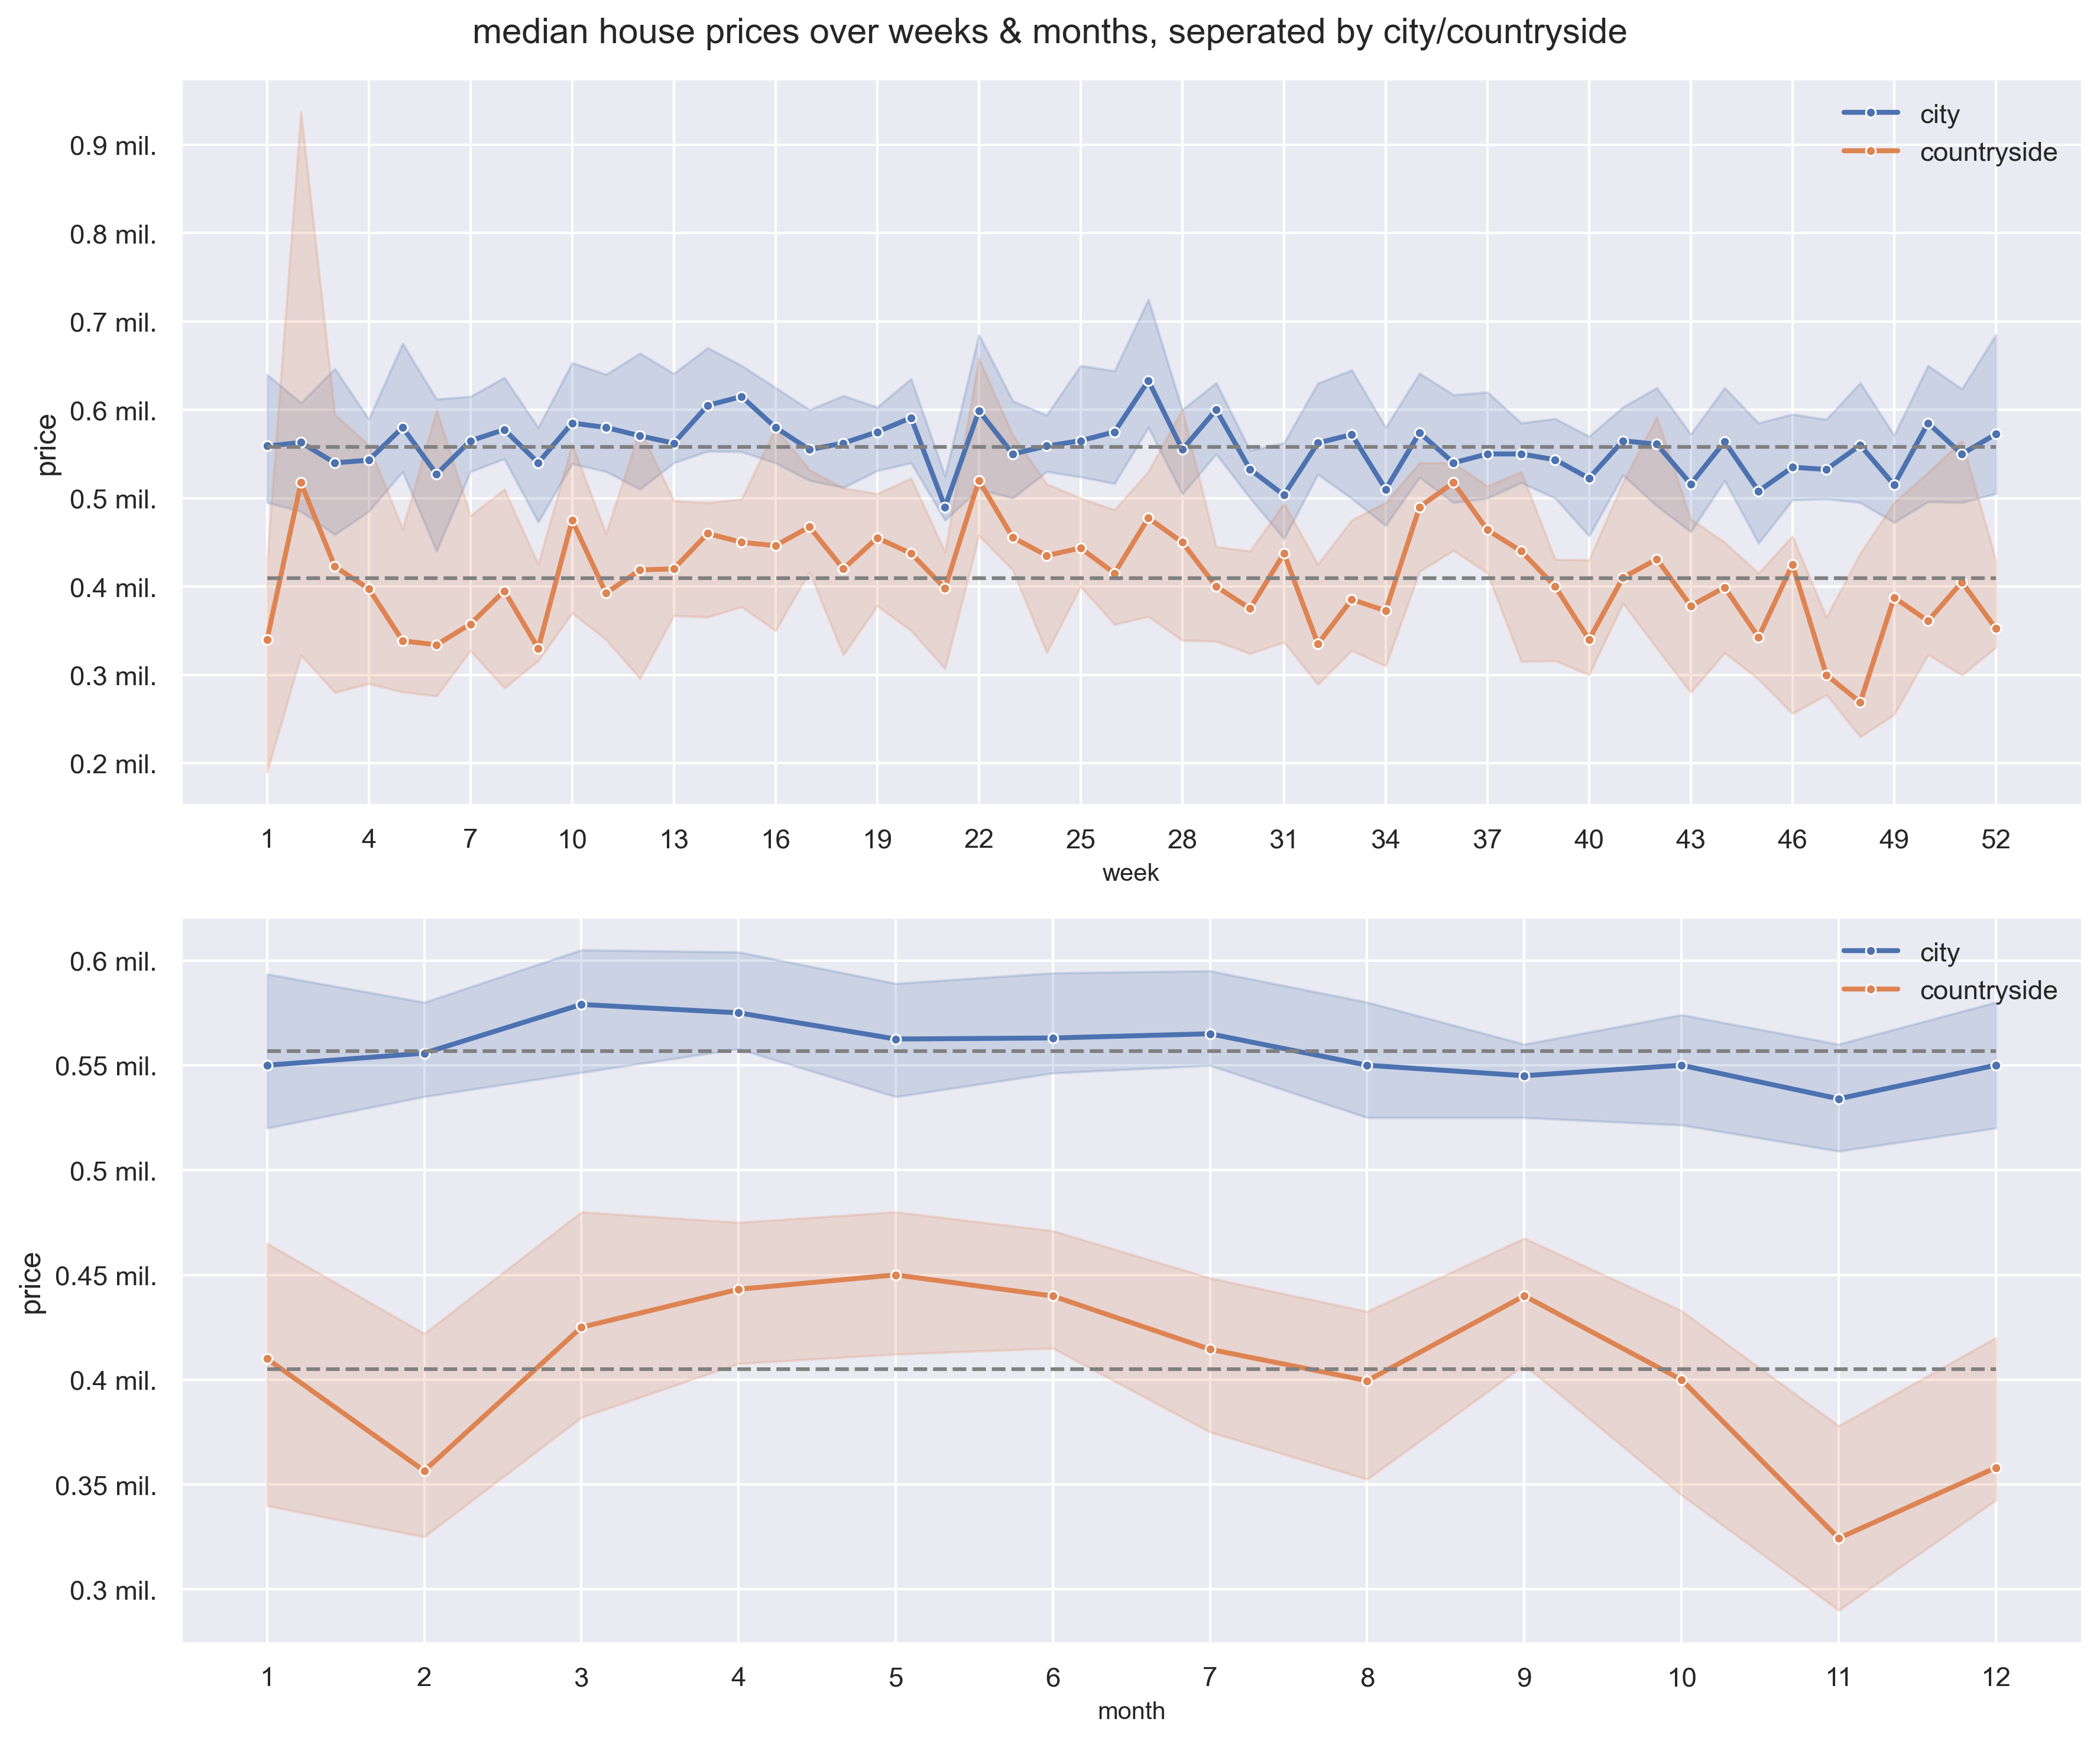

In [81]:
# --- line plot of house proces over weeks/months --- hide code ---
lbl = {0: 'week', 1:'month'}
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('median house prices over weeks & months, seperated by city/countryside')
for i, time_frame in enumerate(['date_week', 'date_month']):
    # time series of prices
    ts = df_cc.groupby(by=[time_frame, 'urbanization'])['price'].median().to_frame().reset_index().sort_values(time_frame)
    # line plot
    sns.lineplot(df_cc, x=time_frame, y="price", hue='urbanization',
                 marker="o", markersize=4, linewidth=2, ax=ax[i],
                 legend='brief', estimator='median')
    # adjust the tick positions and labels
    n_time_frame = df_cc[time_frame].nunique()
    ax[i].set(xticks=np.arange(1, n_time_frame+1, round(n_time_frame/20)))
    # add reference (mean) lines
    ax[i].hlines(y=ts[ts.urbanization == 'city']['price'].mean(),
                 xmin=ts[ts.urbanization == 'city'][time_frame].min(),
                 xmax=ts[ts.urbanization == 'city'][time_frame].max(),
                 linestyles='dashed', colors=[0.5, 0.5, 0.5])
    ax[i].hlines(y=ts[ts.urbanization == 'countryside']['price'].mean(),
                 xmin=ts[ts.urbanization == 'countryside'][time_frame].min(),
                 xmax=ts[ts.urbanization == 'countryside'][time_frame].max(),
                 linestyles='dashed', colors=[0.5, 0.5, 0.5])
    # style axis
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].set_xlabel(lbl[i], fontsize=10)
    ax[i].legend().set_title('')

plt.tight_layout()

### Median price _per disctrict_ and over months

Seperating this time series for all district may give us more insights into possible fluctuation of house prices
Possible effects of location could be, that
- popular regions does not show any fluctuations
- while less popular regions may be affected by the seasons

When seperating into districts, we only look into monthly fluctuations in order to keep as many samples as possible within the time bins.

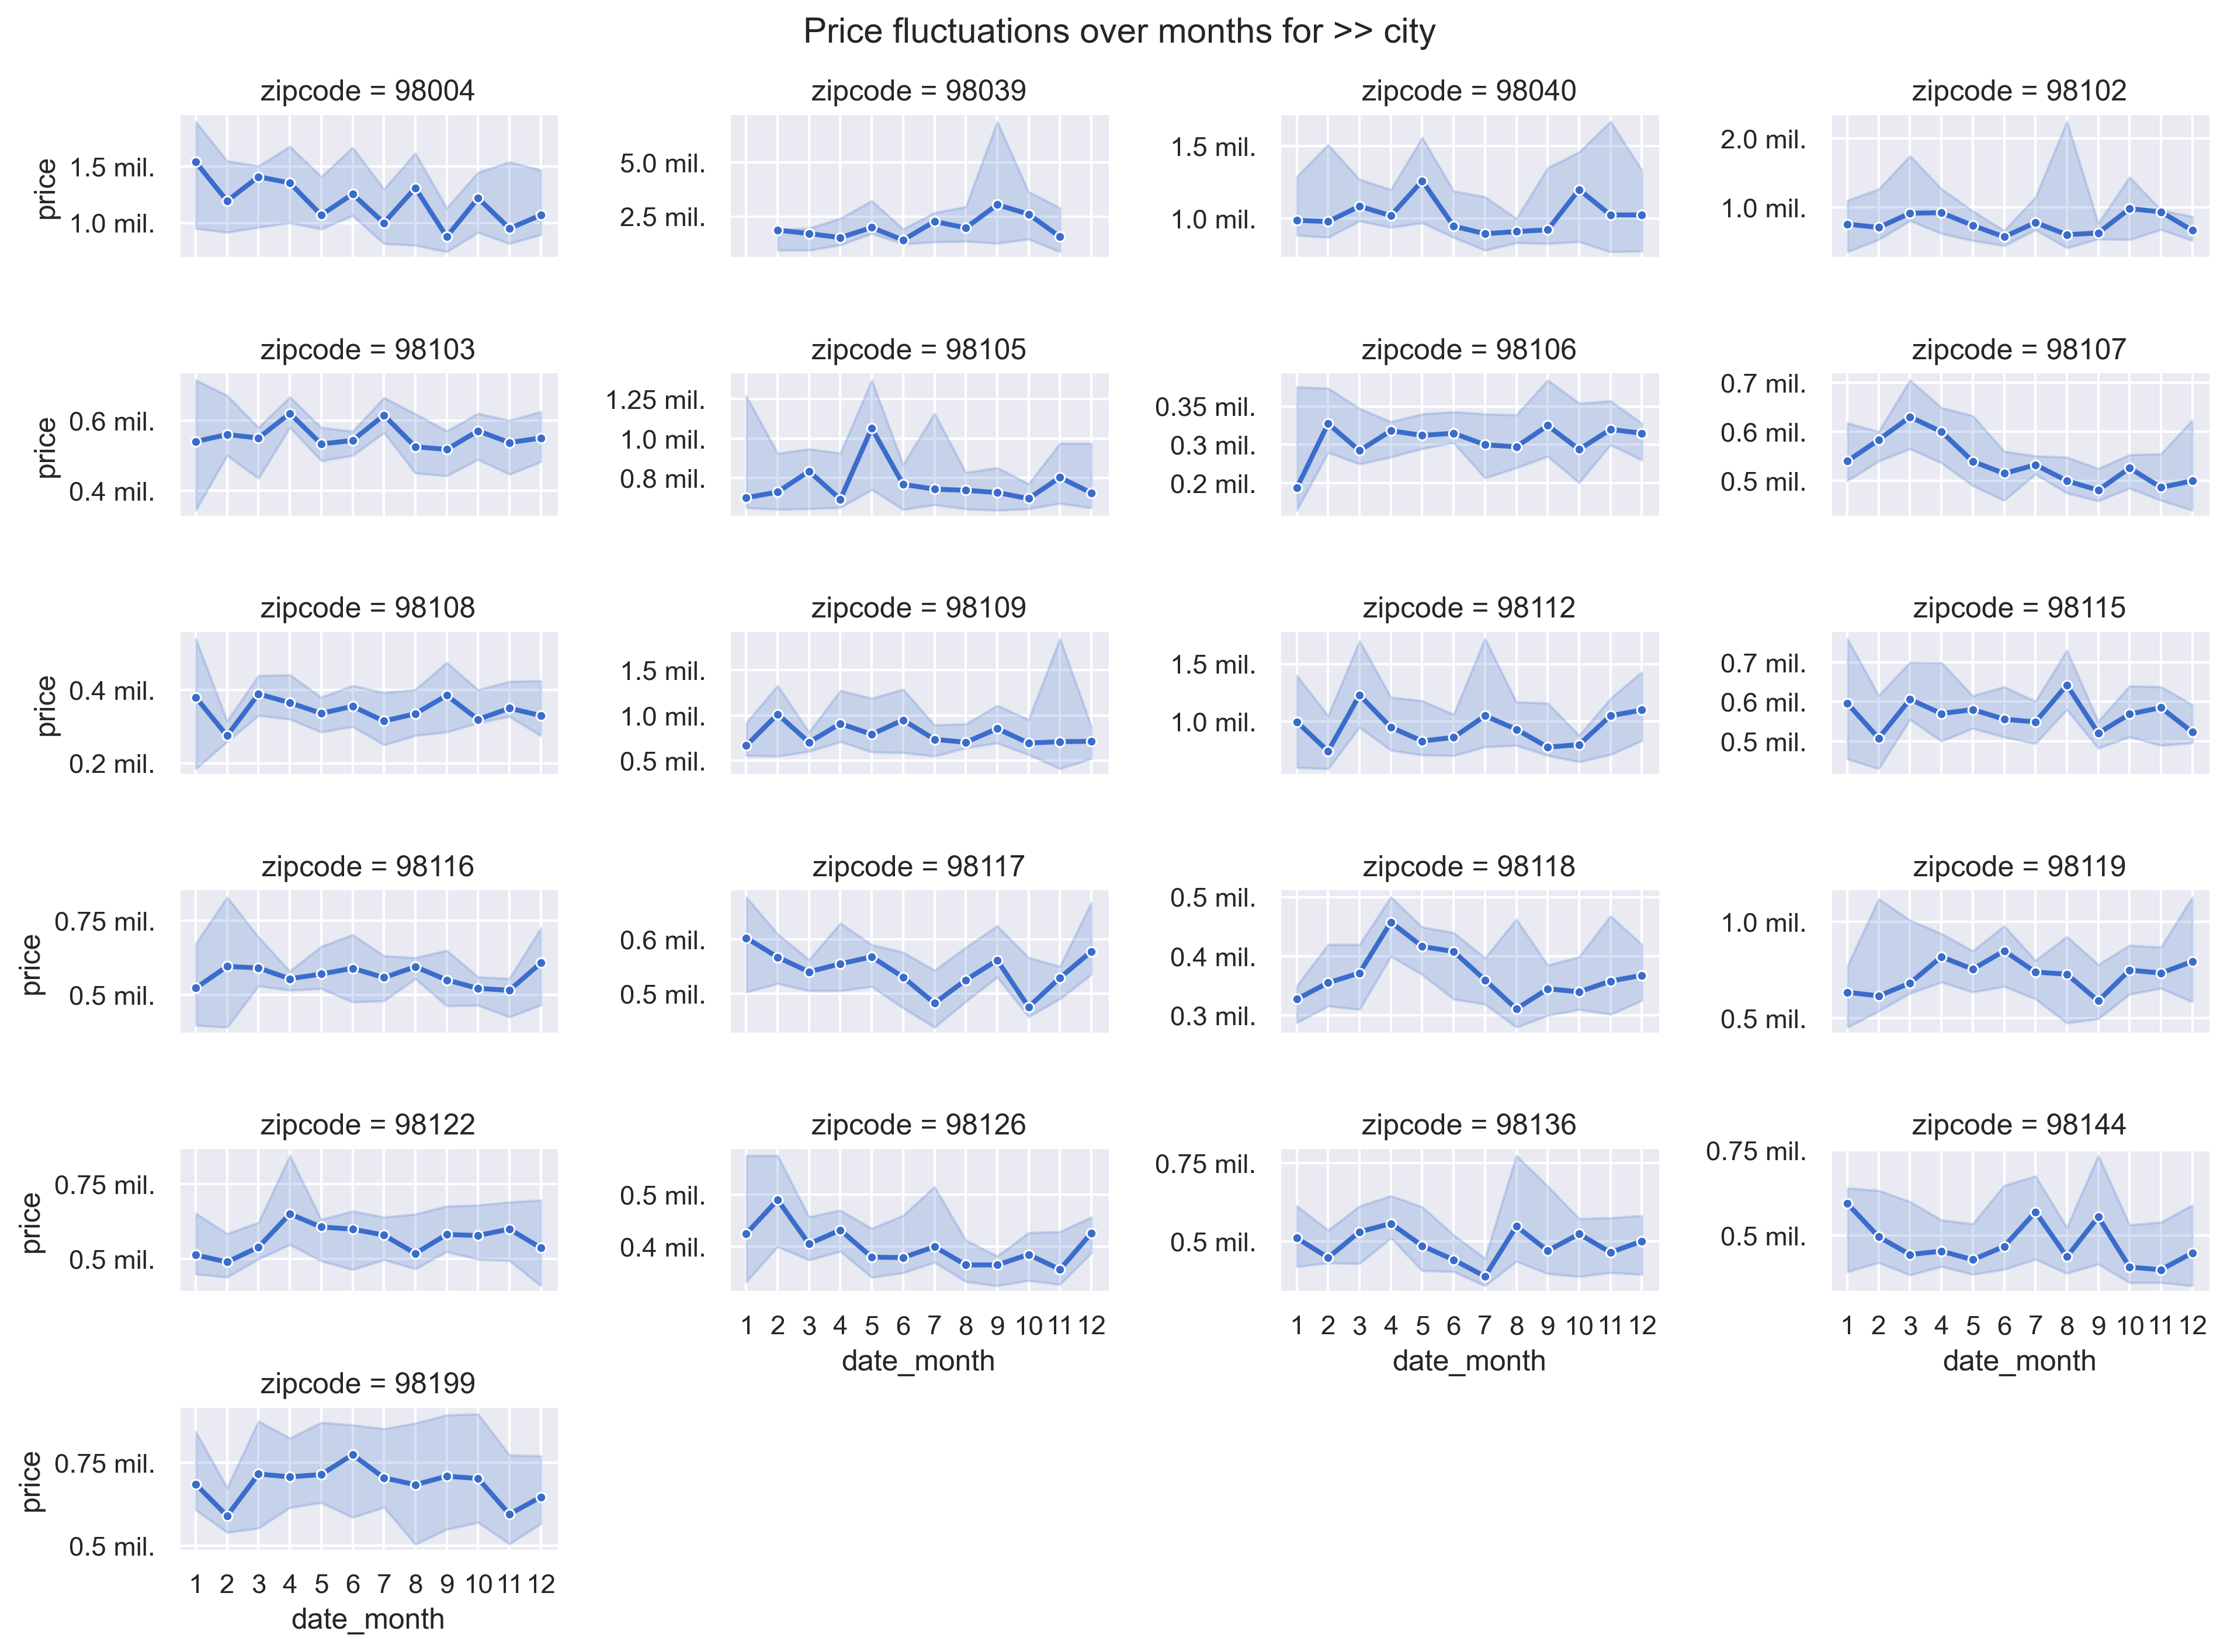

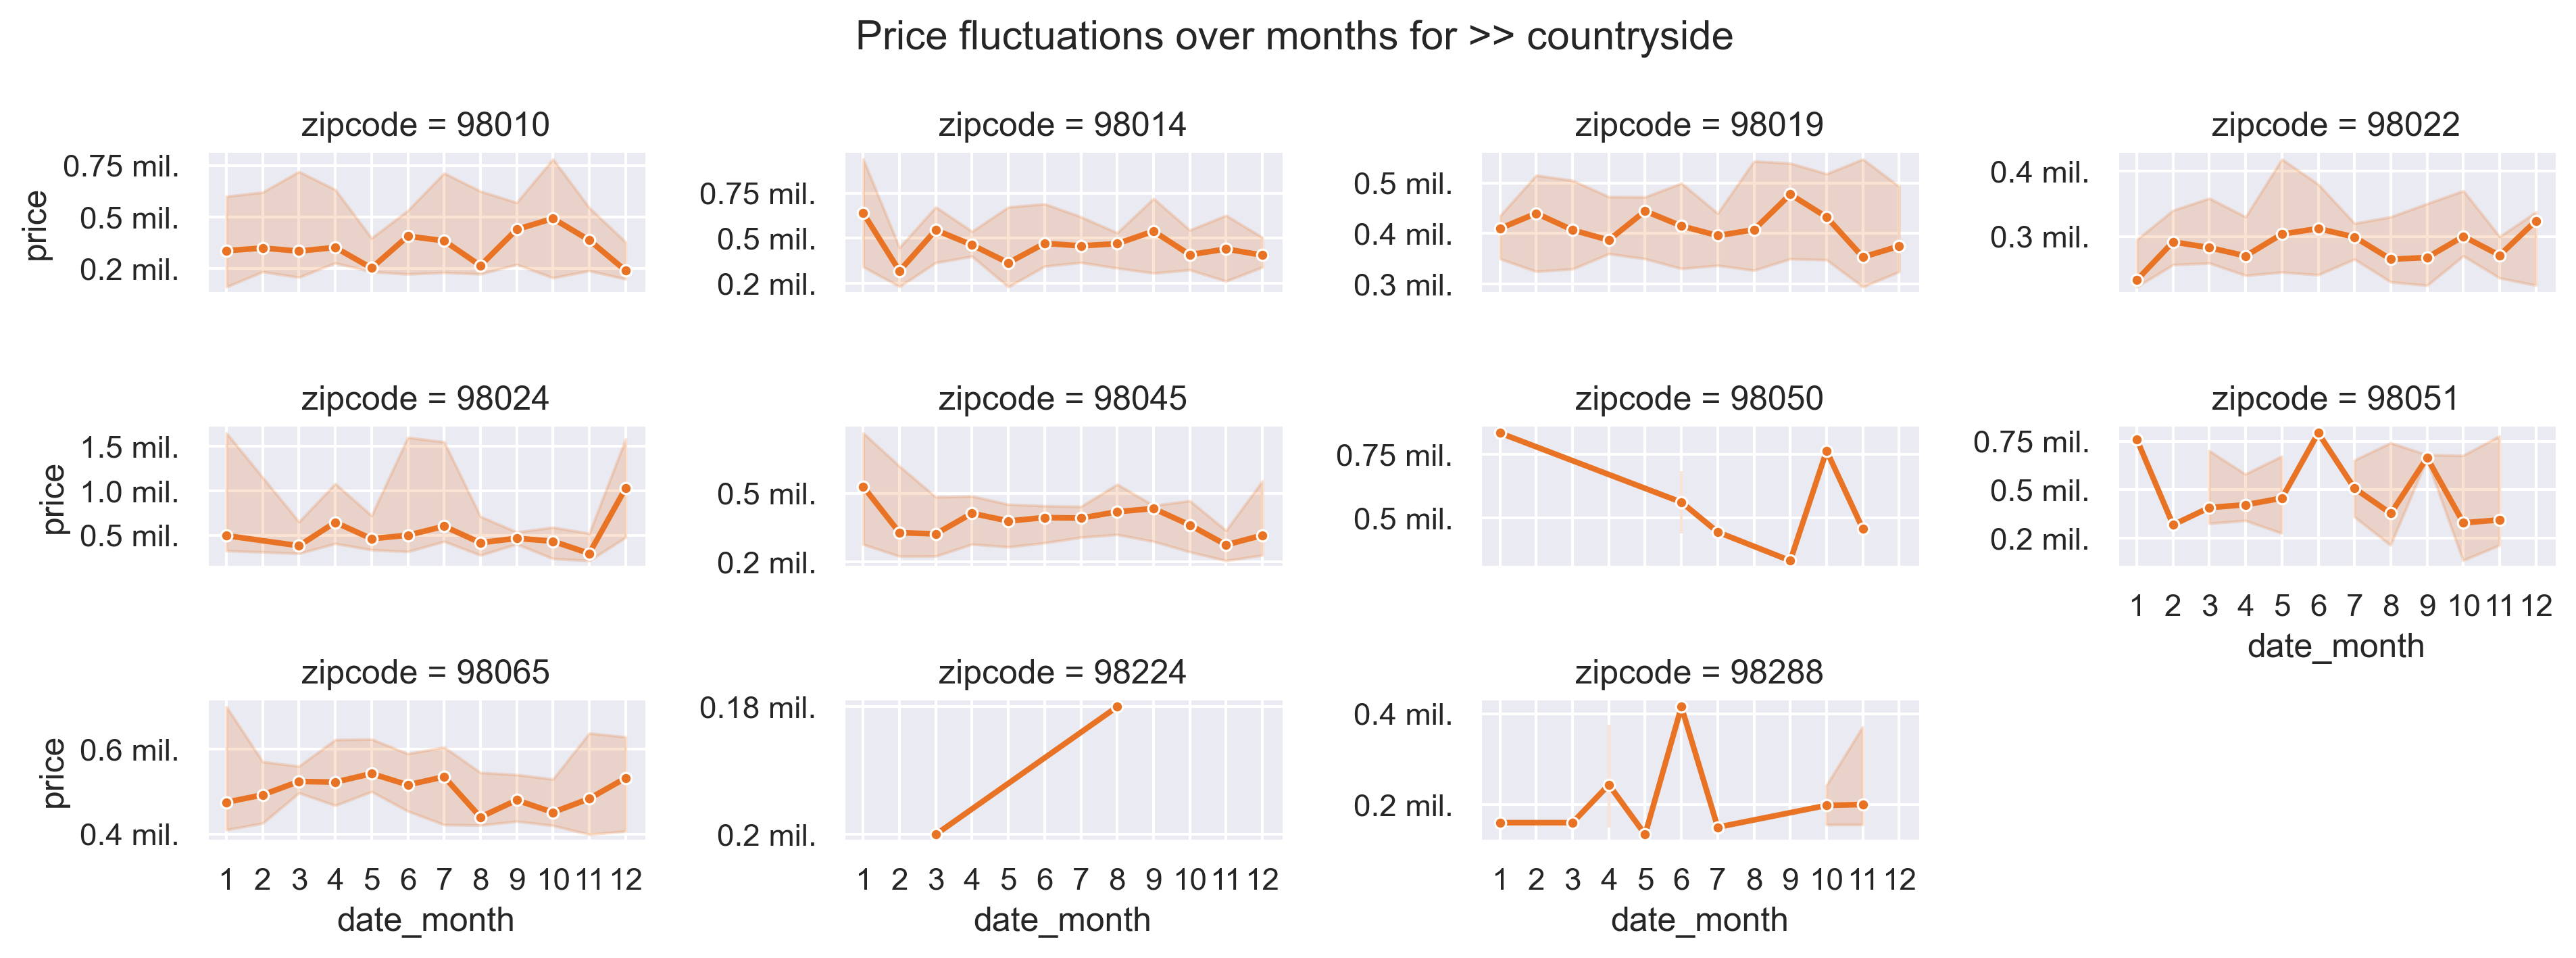

In [82]:
n_time_frame = df_filt['date_month'].nunique()
clrs = {0: "blend:#3a6dcb,#3a6dcb", 1: "blend:#e87325,#e87325"}
for i, c in enumerate(['city', 'countryside']):
    ts =  df.groupby(by=['urbanization', 'zipcode', 'date_month'])['price'].median().to_frame().reset_index().sort_values('date_month')

    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(df[df.urbanization == c], col="zipcode", hue="zipcode", palette=clrs[i],
                         col_wrap=4, height=1.6, aspect=2, sharey=False)
    # title
    grid.figure.suptitle('Price fluctuations over months for >> ' + c)
    # Draw a line plot to show the trajectory of each random walk
    grid.map(sns.lineplot, 'date_month', "price", marker="o", markersize=4, linewidth=2, estimator='median')
    # Adjust the tick positions and labels
    grid.set(xticks=np.arange(1, n_time_frame+1, round(n_time_frame/20)))
    # Adjust the arrangement of the plots
    grid.tight_layout(w_pad=2)

    for ax in grid.axes.flat:
        ax.yaxis.set_major_formatter(formatter)


In [ ]:
df_filt_by_CndBed = df_filt.groupby(by=['urbanization', 'condition', 'bedrooms'])['price'].median().to_frame().reset_index()
df_filt_by_CndBed